In [1]:
import scanpy as sc
import scvi
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

Global seed set to 0


In [2]:
tox_adata = sc.read_h5ad("/project/gilad/jpopp/cellcipher/data/Tox5-full/single_cell_objects/filtered_pflog1ppfnorm.hvg.umap_embedding.h5ad")
tox_adata_raw = sc.read_h5ad("/project/gilad/jpopp/cellcipher/data/Tox5-full/single_cell_objects/filtered.h5ad")

In [3]:
assert tox_adata.obs.index.equals(tox_adata_raw.obs.index)

In [7]:
sc.tl.leiden(tox_adata, resolution=1.25, key_added='leiden')

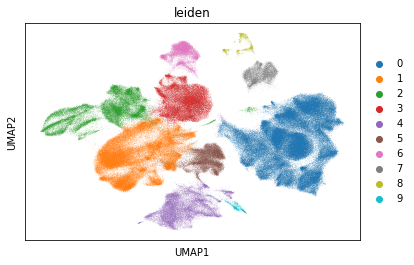

In [4]:
sc.pl.umap(tox_adata, color='leiden')

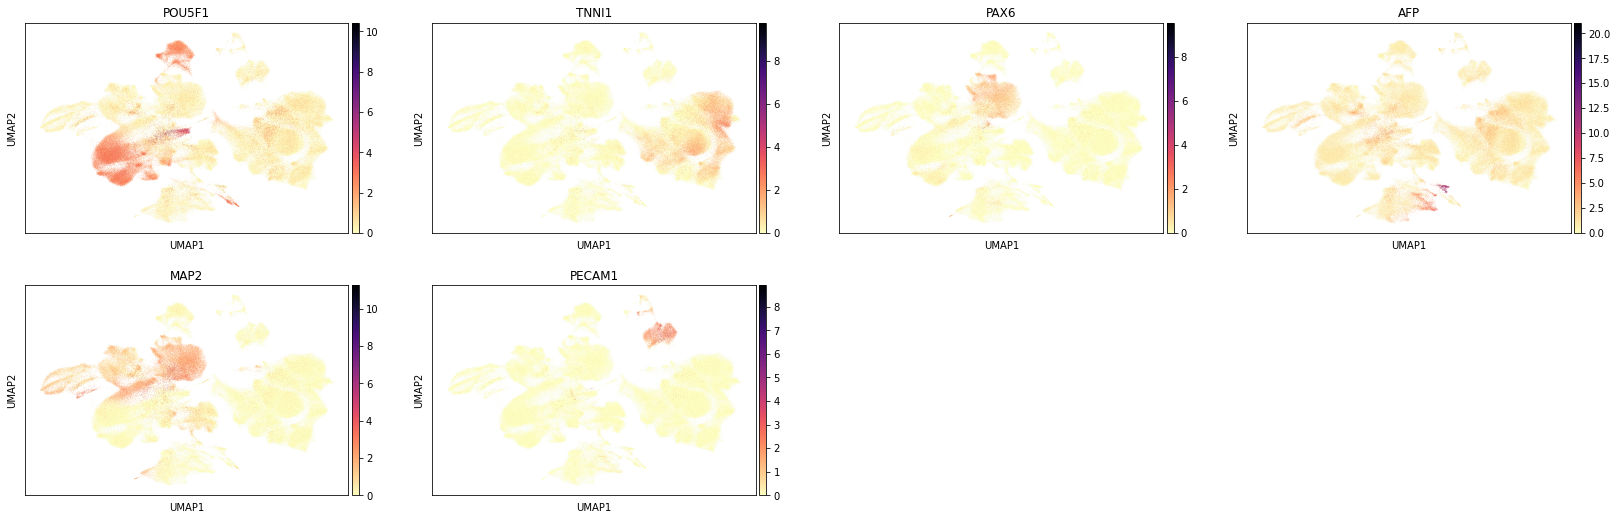

In [5]:
sc.pl.umap(tox_adata, color=['POU5F1', 'TNNI1', 'PAX6', 'AFP', 'MAP2', 'PECAM1'], color_map='magma_r')

In [6]:
celltype_labels = {0: 'mesoderm', 
                   1:'pluripotent', 
                   2: 'neuron', 
                   3: 'earlyecto', 
                   4: 'endoderm', 
                   5: 'pluripotent',
                  6: 'pluripotent',
                  7: 'endothelial',
                  8: 'endothelial',
                  9: 'pluripotent'}

In [7]:
tox_adata.obs['celltype'] = [celltype_labels[int(c)] for c in tox_adata.obs['leiden']]

In [9]:
tox_adata.obs[['treatment']].value_counts()

treatment
Val          51413
Dex          49767
Ent          48865
Ben          47629
Lor          42922
Bus          41027
Muz          38884
Ola          37380
dtype: int64

In [21]:
treatment_map = {
    'Ben': 'Benoxaprofen',
    'Val': 'Valdecoxib',
    'Dex': 'Dextromethorphan',
    'Ent': 'Entacapone',
    'Lor': 'Loratadine',
    'Bus': 'Buspirone',
    'Muz': 'Muzolimine',
    'Ola': 'Olanzapine'
}

In [22]:
tox_adata.obs['treatment_name'] = [treatment_map[t] for t in tox_adata.obs['treatment']]

In [12]:
cell_subset = tox_adata.obs[['sample_id', 'donor_id', 'celltype']]
cell_subset['pseudobulk_sample'] = cell_subset['sample_id'].astype(str) + '_' + cell_subset['donor_id'].astype(str) + '_' + cell_subset['celltype'].astype(str)

/tmp/jobs/31465353/ipykernel_53141/782936707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_subset['pseudobulk_sample'] = cell_subset['sample_id'].astype(str) + '_' + cell_subset['donor_id'].astype(str) + '_' + cell_subset['celltype'].astype(str)


In [13]:
onehot = OneHotEncoder(sparse=True).fit_transform(cell_subset[['pseudobulk_sample']])
onehot

<357887x445 sparse matrix of type '<class 'numpy.float64'>'
	with 357887 stored elements in Compressed Sparse Row format>

In [14]:
pseudobulk_sum = tox_adata_raw.X.transpose() * onehot

In [15]:
pseudobulk_sum = pd.DataFrame(pseudobulk_sum.todense(),
                              index=tox_adata_raw.var_names, 
                              columns=cell_subset['pseudobulk_sample'].astype("category").cat.categories).astype(int)

In [17]:
pseudobulk_sum.to_csv("/project/gilad/jpopp/cellcipher/data/Tox5-full/pseudobulk_expression.tsv", sep="\t")

In [23]:
treatment_dict = tox_adata.obs[['sample_id', 'treatment', 'treatment_name']].drop_duplicates()

In [24]:
treatment_dict

,sample_id,treatment,treatment_name
cell,,,
AAACCCAAGAGAGGGC-1,YG-KR-831-Tox5-07-7-Ben,Ben,Benoxaprofen
AAACCCAAGACAAGCC-2,YG-KR-831-Tox5-15-15-Lor,Lor,Loratadine
AAACCCAAGAACGTGC-3,YG-KR-831-Tox5-05-5-Val,Val,Valdecoxib
AAACCCAAGCGCCTAC-4,YG-KR-831-Tox5-09-9-Bus,Bus,Buspirone
AAACCCAAGCACCGAA-5,YG-KR-831-Tox5-12-12-Ent,Ent,Entacapone
AAACCCAAGAAGTCAT-6,YG-KR-831-Tox5-02-2-Ola,Ola,Olanzapine
AAACCCAAGACCTCAT-7,YG-KR-831-Tox5-14-14-Dex,Dex,Dextromethorphan
AAACCCAAGAACTGAT-8,YG-KR-831-Tox5-01-1-Ola,Ola,Olanzapine
AAACCCAAGACCCTTA-9,YG-KR-831-Tox5-16-16-Lor,Lor,Loratadine


In [25]:
treatment_dict.to_csv("/project/gilad/jpopp/cellcipher/data/Tox5-full/treatment_dict.tsv", sep="\t", index=False)